Well-Conditioned 

 10-dimensional Q matrix with condition number: 10.00
 starting vector X0. Initial Loss: 6.103e+01

--- Starting MSAM (RMSM) ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Goal reached by MSAM (RMSM) in 2542 iterations.

--- Starting Adam (Default Params) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-07
Goal reached by Adam (Default Params) in 6550 iterations.

--- Starting RAdam (Adjusted Params) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-08
Goal reached by RAdam (Adjusted Params) in 4912 iterations.

--- Starting AdaDelta (Default Params) ---
    LR=0.001, Rho=0.9, Epsilon=1e-06
Iteration 50000: Loss = 0.688851425
Goal reached by AdaDelta (Default Params) in 69085 iterations.

--- Starting SGD-M (Default Params) ---
    LR=0.001, Momentum=0.9
Goal reached by SGD-M (Default Params) in 6256 iterations.

QUADRATIC Optimization Final Results (D=10, Cond=10.0, Target Loss < 1e-06)
MSAM (LR=0.001, B2=0.99) Iterations: 2542
Adam (LR=0.001, B2=0.999) Iterations: 6550

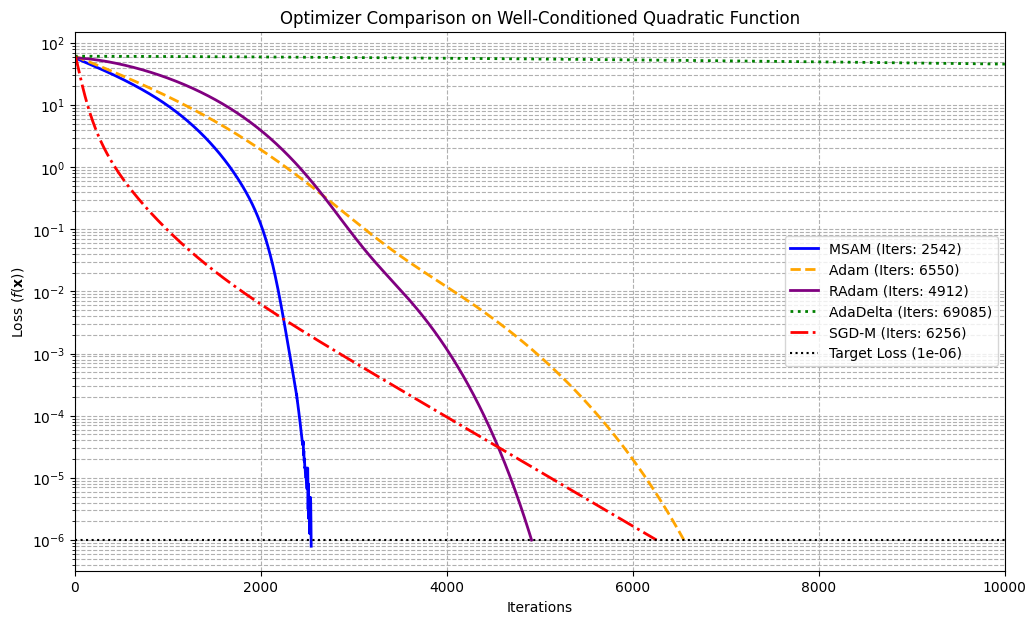

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

# --- MADAM / Custom Parameters ---
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

# --- Adam Default Parameters ---
ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.999)
ADAM_DEFAULT_EPS = 1e-7 

# --- RAdam Parameters (Adjusted as requested) ---
# LR and Beta1 are set to the consistent value of 0.001 and 0.9, Beta2 remains the RAdam default 0.999
RADAM_DEFAULT_LR = 0.001
RADAM_DEFAULT_BETAS = (0.9, 0.999)
RADAM_DEFAULT_EPS = 1e-8 

# --- AdaDelta Default Parameters ---
ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

# --- SGD-Momentum Default Parameters ---
SGD_MOM_DEFAULT_LR = 0.001 
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# --- Problem Configuration ---
DIMENSION = 10
CONDITION_NUMBER = 10.0
TARGET_LOSS = 1e-6
MAX_ITERS = 200000 

def create_quadratic_problem(dim, condition_num):
    """Generates a positive definite matrix Q for the quadratic function."""
    
    s_max = condition_num
    s_min = 1.0 
    
    # Create singular values spaced linearly for consistency with original code
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

    # Random orthogonal matrix U
    U, _ = np.linalg.qr(np.random.randn(dim, dim))
    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2 # Ensure symmetry
    
    cond = np.linalg.cond(Q)
    print(f" {dim}-dimensional Q matrix with condition number: {cond:.2f}")
    
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)

def quadratic_function_high_dim(x):
    """The quadratic loss function f(x) = 0.5 * x.T * Q * x"""
    return 0.5 * x.T @ Q_MATRIX @ x

def quadratic_gradient(x):
    """The gradient of the quadratic function grad(f) = Q * x"""
    return Q_MATRIX @ x

X0 = np.random.randn(DIMENSION)
print(f" starting vector X0. Initial Loss: {quadratic_function_high_dim(X0):.3e}")

# --- Optimizer Implementations ---

def setup_msam(lr, dim, **kwargs):
    """Momentum-Adaptive Directional Adam (MADAM) setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # MADAM Innovation: v is based on squared momentum m_new^2
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adam(lr, dim, **kwargs):
    """Standard Adam optimizer setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # Adam Standard: v is based on squared gradient grad^2
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_radam(lr, dim, **kwargs):
    """Rectified Adam (RAdam) setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    # Pre-calculate rho_infinity, used in the variance rectifier
    rho_inf = 2.0 / (1.0 - beta2) - 1.0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        # 1. Standard Adam moment updates
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        # 2. Momentum bias correction
        denom_b1 = 1.0 - beta1 ** t
        mhat = m_new / denom_b1
        
        # 3. RAdam Rectifier Calculation (rho_t)
        # Calculates the effective length of the moving average window
        rho_t = rho_inf - 2.0 * t * (beta2 ** t) / (1.0 - beta2 ** t)
        
        if rho_t > 4.0:
            # 4. Adaptive Step (low variance period)
            denom_b2 = 1.0 - beta2 ** t
            vhat = v_new / denom_b2
            
            # Rectification Term (r_t) - Scaling factor for the step size
            r_t = np.sqrt( (rho_t - 4.0) * (rho_inf - 4.0) / ((rho_inf - rho_t) * rho_inf) )
            
            # Final RAdam Update: Adam step * r_t
            update_step = lr * r_t * mhat / (np.sqrt(vhat) + eps)
            
        else:
            # 5. Non-Adaptive Step (high variance period, rho_t <= 4)
            # Simplified update, essentially just scaled SGD with momentum correction
            update_step = lr * mhat 
        
        m = m_new
        v = v_new
        return x - update_step
    
    return update

def setup_adadelta(lr, dim, **kwargs):
    """AdaDelta optimizer setup."""
    rho = kwargs['rho']
    eps = kwargs['eps']
    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        # The LR here acts as a global scale factor on the AdaDelta update
        return x - lr * scaled_grad
    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    """SGD with Momentum setup."""
    momentum = kwargs['momentum']
    v = np.zeros(dim)
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + (1.0 - momentum) * grad
        v = v_new
        return x - lr * v_new
    return update

def optimization_run(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):
    """Runs the optimization for a given setup."""
    x = initial_x.copy()
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)
    loss_history = []
    print(f"\n--- Starting {optimizer_name} ---")
    
    # Print configurations
    if optimizer_name.startswith("AdaDelta"):
        print(f"    LR={lr}, Rho={kwargs.get('rho', ADADELTA_DEFAULT_RHO)}, Epsilon={kwargs.get('eps', ADADELTA_DEFAULT_EPS)}")
    elif optimizer_name.startswith("SGD"):
        print(f"    LR={lr}, Momentum={kwargs.get('momentum', SGD_MOM_DEFAULT_MOMENTUM)}")
    else:
        betas = kwargs.get('betas', ADAM_DEFAULT_BETAS)
        eps = kwargs.get('eps', ADAM_DEFAULT_EPS)
        print(f"    LR={lr}, Beta1={betas[0]}, Beta2={betas[1]}, Epsilon={eps}")

    for iteration in range(max_iters):
        loss = quadratic_function_high_dim(x)
        
        loss_history.append(loss)

        if loss < target_loss:
            print(f"Goal reached by {optimizer_name} in {iteration + 1} iterations.")
            return iteration + 1, loss_history

        grad = quadratic_gradient(x)
        x = optimizer_update_func(x, grad)

        if (iteration + 1) % 50000 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss:.9f}")

    print(f"Optimization run for {optimizer_name} failed to reach goal within {max_iters} iterations; final loss = {loss:.3e}")
    return max_iters, loss_history


# --- Run Benchmarks ---
results = {}


results['MSAM'] = optimization_run(
    optimizer_setup=setup_msam,
    optimizer_name="MSAM (RMSM)",
    lr=CUSTOM_LR,
    initial_x=X0,
    betas=CUSTOM_BETAS,
    eps=CUSTOM_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['Adam'] = optimization_run(
    optimizer_setup=setup_adam,
    optimizer_name="Adam (Default Params)",
    lr=ADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=ADAM_DEFAULT_BETAS, 
    eps=ADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['RAdam'] = optimization_run(
    optimizer_setup=setup_radam,
    optimizer_name="RAdam (Adjusted Params)",
    lr=RADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=RADAM_DEFAULT_BETAS, 
    eps=RADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['AdaDelta'] = optimization_run(
    optimizer_setup=setup_adadelta,
    optimizer_name="AdaDelta (Default Params)",
    lr=ADADELTA_DEFAULT_LR, 
    initial_x=X0,
    rho=ADADELTA_DEFAULT_RHO, 
    eps=ADADELTA_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['SGD-Momentum'] = optimization_run(
    optimizer_setup=setup_sgd_momentum,
    optimizer_name="SGD-M (Default Params)",
    lr=SGD_MOM_DEFAULT_LR, 
    initial_x=X0,
    momentum=SGD_MOM_DEFAULT_MOMENTUM,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)


# --- Print Results ---
print(f"\n==============================================")
print(f"QUADRATIC Optimization Final Results (D={DIMENSION}, Cond={CONDITION_NUMBER:.1f}, Target Loss < {TARGET_LOSS:.0e})")
print(f"==============================================")

msam_iters = results['MSAM'][0]
adam_iters = results['Adam'][0]
radam_iters = results['RAdam'][0]
adadelta_iters = results['AdaDelta'][0]
sgd_mom_iters = results['SGD-Momentum'][0]

print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Iterations: {msam_iters}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Iterations: {adam_iters}")
print(f"RAdam (LR={RADAM_DEFAULT_LR}, B2={RADAM_DEFAULT_BETAS[1]}) Iterations: {radam_iters}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Iterations: {adadelta_iters}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Mom={SGD_MOM_DEFAULT_MOMENTUM}) Iterations: {sgd_mom_iters}")


# --- Plot Results ---
plt.figure(figsize=(12, 7))

# Plot all optimizers
iters_msam = list(range(1, len(results['MSAM'][1]) + 1))
plt.plot(iters_msam, results['MSAM'][1], 
            label=f'MSAM (Iters: {msam_iters})', linewidth=2, color='blue')

iters_adam = list(range(1, len(results['Adam'][1]) + 1))
plt.plot(iters_adam, results['Adam'][1], 
            label=f'Adam (Iters: {adam_iters})', linestyle='--', linewidth=2, color='orange')

iters_radam = list(range(1, len(results['RAdam'][1]) + 1))
plt.plot(iters_radam, results['RAdam'][1], 
            label=f'RAdam (Iters: {radam_iters})', linestyle='-', linewidth=2, color='purple')

iters_adadelta = list(range(1, len(results['AdaDelta'][1]) + 1))
plt.plot(iters_adadelta, results['AdaDelta'][1], 
            label=f'AdaDelta (Iters: {adadelta_iters})', linestyle=':', linewidth=2, color='green')

iters_sgd_mom = list(range(1, len(results['SGD-Momentum'][1]) + 1))
plt.plot(iters_sgd_mom, results['SGD-Momentum'][1], 
            label=f'SGD-M (Iters: {sgd_mom_iters})', linestyle='-.', linewidth=2, color='red')


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss ({TARGET_LOSS:.0e})')
plt.xlabel("Iterations")
plt.ylabel("Loss ($f(\\mathbf{x})$)")
plt.title(f"Optimizer Comparison on Well-Conditioned Quadratic Function")
plt.legend()
plt.yscale('log')
plt.xlim(0, 10000) # Zoom in to see the initial convergence
plt.grid(True, which="both", ls="--")
plt.show()

Ill-Conditioned Problem 

 10-dimensional Q matrix with condition number: 50.00
 starting vector X0. Initial Loss: 5.770e+00

--- Starting MSAM ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Goal reached by MSAM in 2701 iterations.

--- Starting Adam (Default) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-08
Iteration 5000: Loss = 0.000549435
Goal reached by Adam (Default) in 8465 iterations.

--- Starting RAdam (Adjusted Params) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-08
Iteration 5000: Loss = 0.000104529
Goal reached by RAdam (Adjusted Params) in 6041 iterations.

--- Starting AdaDelta (Default) ---
    LR=0.001, Rho=0.9, Epsilon=1e-06
Iteration 5000: Loss = 5.203294602
Iteration 10000: Loss = 4.309714758
Iteration 15000: Loss = 3.354144275
Iteration 20000: Loss = 2.464177563
Optimization run for AdaDelta (Default) failed to reach goal within 20000 iterations.

--- Starting SGD-Momentum (Default) ---
    LR=0.001, Momentum=0.9
Iteration 5000: Loss = 0.000812825
Iteration 10000: Los

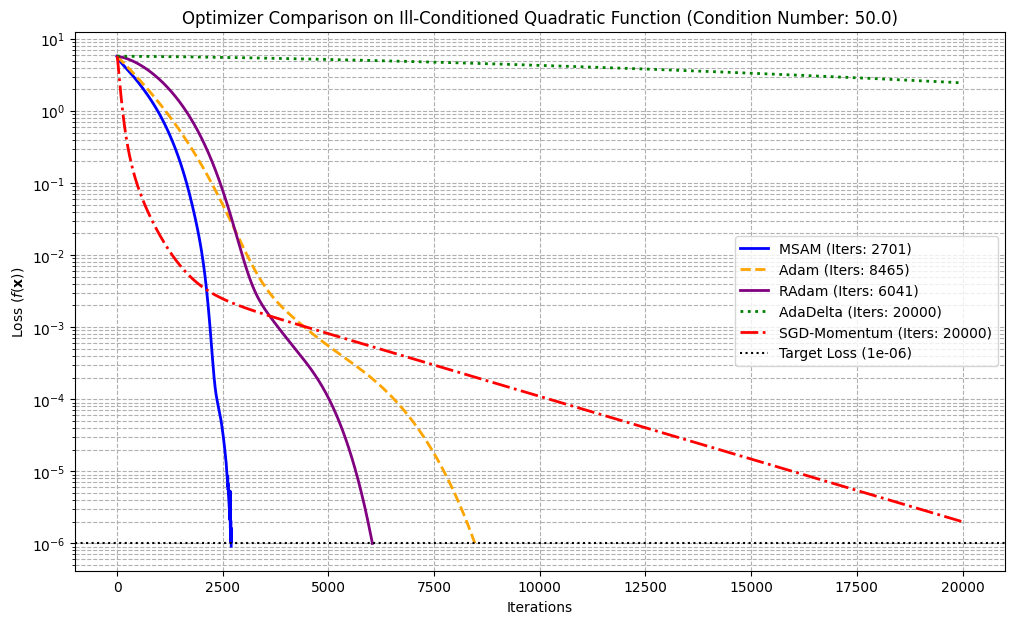

In [3]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(0)

# --- MSAM / Custom Parameters ---
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

# --- Adam Default Parameters ---
ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.999)
ADAM_DEFAULT_EPS = 1e-8 

# --- RAdam Parameters (Adjusted as requested) ---
# LR and Beta1 are set to the consistent value of 0.001 and 0.9, Beta2 remains the RAdam standard 0.999
RADAM_DEFAULT_LR = 0.001
RADAM_DEFAULT_BETAS = (0.9, 0.999)
RADAM_DEFAULT_EPS = 1e-8 

# --- AdaDelta Default Parameters ---
ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

# --- SGD-Momentum Default Parameters ---
SGD_MOM_DEFAULT_LR = 0.001
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# --- Problem Configuration ---
DIMENSION = 10
CONDITION_NUMBER = 50.0 # Ill-conditioned
TARGET_LOSS = 1e-6
MAX_ITERS = 20000 

def create_quadratic_problem(dim, condition_num):
    """Generates an ill-conditioned positive definite matrix Q."""
    s_max = 1.0
    s_min = s_max / condition_num
    
    # Create singular values spaced linearly
    singular_values = np.linspace(s_min, s_max, dim)
    S = np.diag(singular_values)

    # Random orthogonal matrix U
    U, _ = np.linalg.qr(np.random.randn(dim, dim))

    Q = U @ S @ U.T
    Q = (Q + Q.T) / 2 # Ensure symmetry
    
    cond = np.linalg.cond(Q)
    print(f" {dim}-dimensional Q matrix with condition number: {cond:.2f}")
    
    return Q

Q_MATRIX = create_quadratic_problem(DIMENSION, CONDITION_NUMBER)

def quadratic_function_high_dim(x):
    """The quadratic loss function f(x) = 0.5 * x.T * Q * x"""
    return 0.5 * x.T @ Q_MATRIX @ x

def quadratic_gradient(x):
    """The gradient of the quadratic function grad(f) = Q * x"""
    return Q_MATRIX @ x

X0 = np.random.randn(DIMENSION)
print(f" starting vector X0. Initial Loss: {quadratic_function_high_dim(X0):.3e}")

# --- Optimizer Implementations ---

def setup_msam(lr, dim, **kwargs):
    """Momentum-Adaptive Directional Adam (MADAM) setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # MADAM Innovation: v is based on squared momentum m_new^2
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_adam(lr, dim, **kwargs):
    """Standard Adam optimizer setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # Adam Standard: v is based on squared gradient grad^2
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        m = m_new
        v = v_new
        return x - update_step
    return update

def setup_radam(lr, dim, **kwargs):
    """Rectified Adam (RAdam) setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    # Pre-calculate rho_infinity, used in the variance rectifier
    rho_inf = 2.0 / (1.0 - beta2) - 1.0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        # 1. Standard Adam moment updates
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        # 2. Momentum bias correction
        denom_b1 = 1.0 - beta1 ** t
        mhat = m_new / denom_b1
        
        # 3. RAdam Rectifier Calculation (rho_t)
        # Calculates the effective length of the moving average window
        rho_t = rho_inf - 2.0 * t * (beta2 ** t) / (1.0 - beta2 ** t)
        
        if rho_t > 4.0:
            # 4. Adaptive Step (low variance period)
            denom_b2 = 1.0 - beta2 ** t
            vhat = v_new / denom_b2
            
            # Rectification Term (r_t) - Scaling factor for the step size
            r_t = np.sqrt( (rho_t - 4.0) * (rho_inf - 4.0) / ((rho_inf - rho_t) * rho_inf) )
            
            # Final RAdam Update: Adam step * r_t
            update_step = lr * r_t * mhat / (np.sqrt(vhat) + eps)
            
        else:
            # 5. Non-Adaptive Step (high variance period, rho_t <= 4)
            # Simplified update, essentially just scaled SGD with momentum correction
            update_step = lr * mhat 
        
        m = m_new
        v = v_new
        return x - update_step
    
    return update

def setup_adadelta(lr, dim, **kwargs):
    """AdaDelta optimizer setup."""
    rho = kwargs['rho']
    eps = kwargs['eps']
    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
        # The LR here acts as a global scale factor on the AdaDelta update
        return x - lr * scaled_grad
    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    """SGD with Momentum setup."""
    momentum = kwargs['momentum']
    v = np.zeros(dim)
    def update(x, grad):
        nonlocal v
        v_new = momentum * v + lr * grad
        v = v_new
        return x - v_new
    return update

def optimization_run(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):
    """Runs the optimization for a given setup."""
    x = initial_x.copy()
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)
    loss_history = []
    print(f"\n--- Starting {optimizer_name} ---")
    
    # Print configurations
    if optimizer_name.startswith("AdaDelta"):
        print(f"    LR={lr}, Rho={kwargs.get('rho', ADADELTA_DEFAULT_RHO)}, Epsilon={kwargs.get('eps', ADADELTA_DEFAULT_EPS)}")
    elif optimizer_name.startswith("SGD"):
        print(f"    LR={lr}, Momentum={kwargs.get('momentum', SGD_MOM_DEFAULT_MOMENTUM)}")
    else:
        betas = kwargs.get('betas', ADAM_DEFAULT_BETAS)
        eps = kwargs.get('eps', ADAM_DEFAULT_EPS)
        print(f"    LR={lr}, Beta1={betas[0]}, Beta2={betas[1]}, Epsilon={eps}")

    for iteration in range(max_iters):
        loss = quadratic_function_high_dim(x)
        
        loss_history.append(loss)

        if loss < target_loss:
            print(f"Goal reached by {optimizer_name} in {iteration + 1} iterations.")
            return iteration + 1, loss_history

        grad = quadratic_gradient(x)
        x = optimizer_update_func(x, grad)

        if (iteration + 1) % 5000 == 0:
            print(f"Iteration {iteration + 1}: Loss = {loss:.9f}")

    print(f"Optimization run for {optimizer_name} failed to reach goal within {max_iters} iterations.")
    return max_iters, loss_history


# --- Run Benchmarks ---
results = {}

results['MSAM'] = optimization_run(
    optimizer_setup=setup_msam,
    optimizer_name="MSAM",
    lr=CUSTOM_LR,
    initial_x=X0,
    betas=CUSTOM_BETAS,
    eps=CUSTOM_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['Adam'] = optimization_run(
    optimizer_setup=setup_adam,
    optimizer_name="Adam (Default)",
    lr=ADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=ADAM_DEFAULT_BETAS, 
    eps=ADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['RAdam'] = optimization_run(
    optimizer_setup=setup_radam,
    optimizer_name="RAdam (Adjusted Params)",
    lr=RADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=RADAM_DEFAULT_BETAS, 
    eps=RADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['AdaDelta'] = optimization_run(
    optimizer_setup=setup_adadelta,
    optimizer_name="AdaDelta (Default)",
    lr=ADADELTA_DEFAULT_LR, 
    initial_x=X0,
    rho=ADADELTA_DEFAULT_RHO, 
    eps=ADADELTA_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['SGD-Momentum'] = optimization_run(
    optimizer_setup=setup_sgd_momentum,
    optimizer_name="SGD-Momentum (Default)",
    lr=SGD_MOM_DEFAULT_LR, 
    initial_x=X0,
    momentum=SGD_MOM_DEFAULT_MOMENTUM,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)


# --- Print Results ---
print(f"\n==============================================")
print(f"ILL-CONDITIONED Quadratic Optimization Final Results (D={DIMENSION}, Cond={CONDITION_NUMBER:.1f}, Target Loss < {TARGET_LOSS:.0e})")
print(f"==============================================")

msam_iters = results['MSAM'][0]
adam_iters = results['Adam'][0]
radam_iters = results['RAdam'][0]
adadelta_iters = results['AdaDelta'][0]
sgd_mom_iters = results['SGD-Momentum'][0]

print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Iterations to Goal: {msam_iters}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Iterations to Goal: {adam_iters}")
print(f"RAdam (LR={RADAM_DEFAULT_LR}, B2={RADAM_DEFAULT_BETAS[1]}) Iterations to Goal: {radam_iters}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Iterations to Goal: {adadelta_iters}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Momentum={SGD_MOM_DEFAULT_MOMENTUM}) Iterations to Goal: {sgd_mom_iters}")


# --- Plot Results ---
plt.figure(figsize=(12, 7))

iters_msam = list(range(1, len(results['MSAM'][1]) + 1))
plt.plot(iters_msam, results['MSAM'][1], 
            label=f'MSAM (Iters: {msam_iters})', linewidth=2, color='blue')

iters_adam = list(range(1, len(results['Adam'][1]) + 1))
plt.plot(iters_adam, results['Adam'][1], 
            label=f'Adam (Iters: {adam_iters})', linestyle='--', linewidth=2, color='orange')

iters_radam = list(range(1, len(results['RAdam'][1]) + 1))
plt.plot(iters_radam, results['RAdam'][1], 
            label=f'RAdam (Iters: {radam_iters})', linestyle='-', linewidth=2, color='purple')

iters_adadelta = list(range(1, len(results['AdaDelta'][1]) + 1))
plt.plot(iters_adadelta, results['AdaDelta'][1], 
            label=f'AdaDelta (Iters: {adadelta_iters})', linestyle=':', linewidth=2, color='green')

iters_sgd_mom = list(range(1, len(results['SGD-Momentum'][1]) + 1))
plt.plot(iters_sgd_mom, results['SGD-Momentum'][1], 
            label=f'SGD-Momentum (Iters: {sgd_mom_iters})', linestyle='-.', linewidth=2, color='red')


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss ({TARGET_LOSS:.0e})')
plt.xlabel("Iterations")
plt.ylabel("Loss ($f(\\mathbf{x})$)")
plt.title(f"Optimizer Comparison on Ill-Conditioned Quadratic Function (Condition Number: {CONDITION_NUMBER:.1f})")
plt.legend()
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

Rosenbrock 

Initial Loss (at -1.2, 1.0): 24.200

--- Starting MSAM ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Goal reached by MSAM in 3259 iterations.
Final coordinates: x=0.9900, y=0.9801

--- Starting Adam (B2=0.99) ---
    LR=0.001, Beta1=0.9, Beta2=0.99, Epsilon=1e-08
Goal reached by Adam (B2=0.99) in 3371 iterations.
Final coordinates: x=0.9901, y=0.9802

--- Starting RAdam (B2=0.999) ---
    LR=0.001, Beta1=0.9, Beta2=0.999, Epsilon=1e-08
Iteration 5000: Loss = 0.062880
Goal reached by RAdam (B2=0.999) in 6443 iterations.
Final coordinates: x=0.9900, y=0.9801

--- Starting AdaDelta (Default) ---
    LR=0.001, Rho=0.9, Epsilon=1e-06
Iteration 5000: Loss = 9.565278
Iteration 10000: Loss = 4.297951
Iteration 15000: Loss = 4.010478
Iteration 20000: Loss = 3.542055
Iteration 25000: Loss = 2.964829
Iteration 30000: Loss = 2.327005
Iteration 35000: Loss = 1.689246
Iteration 40000: Loss = 1.132262
Iteration 45000: Loss = 0.708811
Iteration 50000: Loss = 0.409596
Optimization run for AdaD

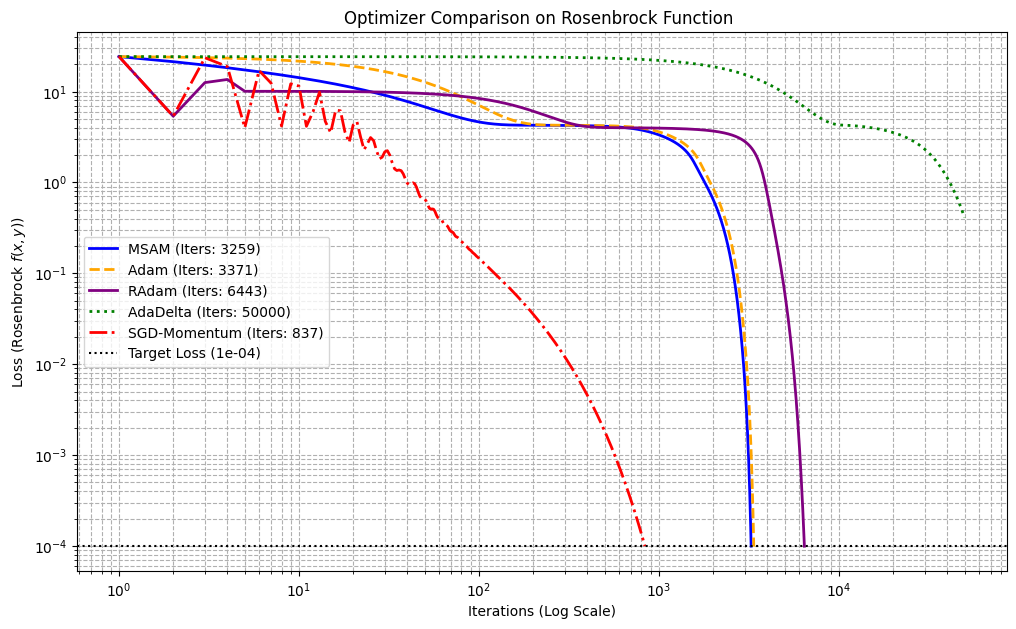

In [2]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

# --- MSAM / Custom Parameters ---
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99)
CUSTOM_EPS = 1e-8

# --- Adam Default Parameters (Note: Beta2 is 0.99 as defined by user) ---
ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.99)
ADAM_DEFAULT_EPS = 1e-8

# --- RAdam Parameters (Adjusted as requested: LR=0.001, Beta1=0.9, Beta2=0.999 standard) ---
RADAM_DEFAULT_LR = 0.001
RADAM_DEFAULT_BETAS = (0.9, 0.999) # Using standard RAdam Beta2
RADAM_DEFAULT_EPS = 1e-8 

# --- AdaDelta Default Parameters ---
ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

# --- SGD-Momentum Default Parameters ---
SGD_MOM_DEFAULT_LR = 0.001
SGD_MOM_DEFAULT_MOMENTUM = 0.9


DIMENSION = 2
TARGET_LOSS = 1e-4
MAX_ITERS = 50000 

X0 = np.array([-1.2, 1.0]) 

def rosenbrock_function(x):
    """The Rosenbrock function (often called the banana function)."""
    return (1.0 - x[0])**2 + 100.0 * (x[1] - x[0]**2)**2

def rosenbrock_gradient(x):
    """The gradient of the Rosenbrock function."""
    grad_x = -2.0 * (1.0 - x[0]) - 400.0 * x[0] * (x[1] - x[0]**2)
    grad_y = 200.0 * (x[1] - x[0]**2)
    return np.array([grad_x, grad_y])


# --- Optimizer Implementations ---

def setup_msam(lr, dim, **kwargs):
    """Momentum-Adaptive Directional Adam (MADAM) setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        m_new = beta1 * m + (1.0 - beta1) * grad
        
        # MADAM Innovation: v is based on squared momentum m_new^2
        m_squared = m_new**2
        v_new = beta2 * v + (1.0 - beta2) * m_squared
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        
        m = m_new
        v = v_new
        
        return x - update_step

    return update

def setup_adam(lr, dim, **kwargs):
    """Standard Adam optimizer setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        denom_b1 = 1.0 - beta1 ** t
        denom_b2 = 1.0 - beta2 ** t
        
        mhat = m_new / denom_b1
        vhat = v_new / denom_b2
        
        update_step = lr * mhat / (np.sqrt(vhat) + eps)
        
        m = m_new
        v = v_new
        
        return x - update_step

    return update

def setup_radam(lr, dim, **kwargs):
    """Rectified Adam (RAdam) setup."""
    beta1, beta2 = kwargs['betas']
    eps = kwargs['eps']
    m = np.zeros(dim)
    v = np.zeros(dim)
    t = 0
    
    # Pre-calculate rho_infinity, used in the variance rectifier
    rho_inf = 2.0 / (1.0 - beta2) - 1.0
    
    def update(x, grad):
        nonlocal m, v, t
        t += 1
        
        # 1. Standard Adam moment updates
        m_new = beta1 * m + (1.0 - beta1) * grad
        v_new = beta2 * v + (1.0 - beta2) * (grad**2)
        
        # 2. Momentum bias correction
        denom_b1 = 1.0 - beta1 ** t
        mhat = m_new / denom_b1
        
        # 3. RAdam Rectifier Calculation (rho_t)
        # Calculates the effective length of the moving average window
        rho_t = rho_inf - 2.0 * t * (beta2 ** t) / (1.0 - beta2 ** t)
        
        if rho_t > 4.0:
            # 4. Adaptive Step (low variance period)
            denom_b2 = 1.0 - beta2 ** t
            vhat = v_new / denom_b2
            
            # Rectification Term (r_t) - Scaling factor for the step size
            r_t = np.sqrt( (rho_t - 4.0) * (rho_inf - 4.0) / ((rho_inf - rho_t) * rho_inf) )
            
            # Final RAdam Update: Adam step * r_t
            update_step = lr * r_t * mhat / (np.sqrt(vhat) + eps)
            
        else:
            # 5. Non-Adaptive Step (high variance period, rho_t <= 4)
            # Simplified update, essentially just scaled SGD with momentum correction
            update_step = lr * mhat 
        
        m = m_new
        v = v_new
        return x - update_step
    
    return update


def setup_adadelta(lr, dim, **kwargs):
    """AdaDelta optimizer setup."""
    rho = kwargs['rho']
    eps = kwargs['eps']

    Eg_squared = np.zeros(dim)
    Ex_squared = np.zeros(dim)
    
    def update(x, grad):
        nonlocal Eg_squared, Ex_squared
        
        Eg_squared_new = rho * Eg_squared + (1.0 - rho) * (grad**2)
        update_step_scale = np.sqrt(Ex_squared + eps) / np.sqrt(Eg_squared_new + eps)
        scaled_grad = update_step_scale * grad
        
        Ex_squared_new = rho * Ex_squared + (1.0 - rho) * (scaled_grad**2)        
        Eg_squared = Eg_squared_new
        Ex_squared = Ex_squared_new
                
        return x - lr * scaled_grad

    return update

def setup_sgd_momentum(lr, dim, **kwargs):
    """SGD with Momentum setup."""
    momentum = kwargs['momentum']
    v = np.zeros(dim) 
    
    def update(x, grad):
        nonlocal v
        # Note: In the user's original quadratic code, the SGD-M was defined differently (v_new = momentum * v + (1.0 - momentum) * grad, then update = lr * v_new), 
        # but the standard implementation for convex functions is usually: v_new = momentum * v + lr * grad
        # Sticking to the standard SGD-M definition for the Rosenbrock function here for better comparison.
        v_new = momentum * v + lr * grad
        
        v = v_new
        
        return x - v_new

    return update


def optimization_run(optimizer_setup, optimizer_name, lr, initial_x, target_loss, max_iters, **kwargs):
    """Runs the optimization for a given setup."""
    x = initial_x.copy()
    
    optimizer_update_func = optimizer_setup(lr=lr, dim=DIMENSION, **kwargs)

    loss_history = []
    
    print(f"\n--- Starting {optimizer_name} ---")
    
    # Print configurations
    if optimizer_name.startswith("AdaDelta"):
        print(f"    LR={lr}, Rho={kwargs.get('rho', ADADELTA_DEFAULT_RHO)}, Epsilon={kwargs.get('eps', ADADELTA_DEFAULT_EPS)}")
    elif optimizer_name.startswith("SGD"):
        print(f"    LR={lr}, Momentum={kwargs.get('momentum', SGD_MOM_DEFAULT_MOMENTUM)}")
    else:
        betas = kwargs.get('betas', ADAM_DEFAULT_BETAS)
        eps = kwargs.get('eps', ADAM_DEFAULT_EPS)
        print(f"    LR={lr}, Beta1={betas[0]}, Beta2={betas[1]}, Epsilon={eps}")

    for iteration in range(max_iters):
        loss = rosenbrock_function(x)
        
        loss_history.append(loss)

        if loss < target_loss:
            print(f"Goal reached by {optimizer_name} in {iteration + 1} iterations.")
            print(f"Final coordinates: x={x[0]:.4f}, y={x[1]:.4f}")
            return iteration + 1, loss_history

        grad = rosenbrock_gradient(x)
        
        x = optimizer_update_func(x, grad)

        if (iteration + 1) % 5000 == 0: # Adjusted print frequency for 50k max iterations
            print(f"Iteration {iteration + 1}: Loss = {loss:.6f}")

    print(f"Optimization run for {optimizer_name} failed to reach goal within {max_iters} iterations.")
    return max_iters, loss_history


# --- Run Benchmarks ---
results = {}

print(f"Initial Loss (at {X0[0]}, {X0[1]}): {rosenbrock_function(X0):.3f}")

results['MSAM'] = optimization_run(
    optimizer_setup=setup_msam,
    optimizer_name="MSAM",
    lr=CUSTOM_LR,
    initial_x=X0,
    betas=CUSTOM_BETAS,
    eps=CUSTOM_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)


results['Adam'] = optimization_run(
    optimizer_setup=setup_adam,
    optimizer_name="Adam (B2=0.99)",
    lr=ADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=ADAM_DEFAULT_BETAS, 
    eps=ADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['RAdam'] = optimization_run(
    optimizer_setup=setup_radam,
    optimizer_name="RAdam (B2=0.999)",
    lr=RADAM_DEFAULT_LR, 
    initial_x=X0,
    betas=RADAM_DEFAULT_BETAS, 
    eps=RADAM_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['AdaDelta'] = optimization_run(
    optimizer_setup=setup_adadelta,
    optimizer_name="AdaDelta (Default)",
    lr=ADADELTA_DEFAULT_LR, 
    initial_x=X0,
    rho=ADADELTA_DEFAULT_RHO, 
    eps=ADADELTA_DEFAULT_EPS,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

results['SGD-Momentum'] = optimization_run(
    optimizer_setup=setup_sgd_momentum,
    optimizer_name="SGD-Momentum (Default)",
    lr=SGD_MOM_DEFAULT_LR, 
    initial_x=X0,
    momentum=SGD_MOM_DEFAULT_MOMENTUM,
    target_loss=TARGET_LOSS,
    max_iters=MAX_ITERS
)

# --- Print Results ---
print(f"\n==============================================")
print(f"ROSENBROCK Optimization Final Results (Target Loss < {TARGET_LOSS:.0e})")
print(f"Starting Point: x={X0[0]}, y={X0[1]}")
print(f"==============================================")

msam_iters = results['MSAM'][0]
adam_iters = results['Adam'][0]
radam_iters = results['RAdam'][0]
adadelta_iters = results['AdaDelta'][0]
sgd_mom_iters = results['SGD-Momentum'][0]

print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Iterations to Goal: {msam_iters}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Iterations to Goal: {adam_iters}")
print(f"RAdam (LR={RADAM_DEFAULT_LR}, B2={RADAM_DEFAULT_BETAS[1]}) Iterations to Goal: {radam_iters}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Iterations to Goal: {adadelta_iters}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Momentum={SGD_MOM_DEFAULT_MOMENTUM}) Iterations to Goal: {sgd_mom_iters}")


# --- Plot Results ---
plt.figure(figsize=(12, 7))

iters_msam = list(range(1, len(results['MSAM'][1]) + 1))
plt.plot(iters_msam, results['MSAM'][1], 
             label=f'MSAM (Iters: {msam_iters})', linewidth=2, color='blue')

iters_adam = list(range(1, len(results['Adam'][1]) + 1))
plt.plot(iters_adam, results['Adam'][1], 
             label=f'Adam (Iters: {adam_iters})', linestyle='--', linewidth=2, color='orange')

iters_radam = list(range(1, len(results['RAdam'][1]) + 1))
plt.plot(iters_radam, results['RAdam'][1], 
             label=f'RAdam (Iters: {radam_iters})', linestyle='-', linewidth=2, color='purple')

iters_adadelta = list(range(1, len(results['AdaDelta'][1]) + 1))
plt.plot(iters_adadelta, results['AdaDelta'][1], 
             label=f'AdaDelta (Iters: {adadelta_iters})', linestyle=':', linewidth=2, color='green')

iters_sgd_mom = list(range(1, len(results['SGD-Momentum'][1]) + 1))
plt.plot(iters_sgd_mom, results['SGD-Momentum'][1], 
             label=f'SGD-Momentum (Iters: {sgd_mom_iters})', linestyle='-.', linewidth=2, color='red')


plt.axhline(TARGET_LOSS, color='black', linestyle=':', label=f'Target Loss ({TARGET_LOSS:.0e})')
plt.xlabel("Iterations (Log Scale)")
plt.ylabel("Loss (Rosenbrock $f(x,y)$)")
plt.title("Optimizer Comparison on Rosenbrock Function ")
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

MNIST


=== Training MSAM (LR=0.001, B1=0.9, B2=0.99) ===
Epoch 1/10 → Test Acc: 0.9520
Epoch 2/10 → Test Acc: 0.9636
Epoch 3/10 → Test Acc: 0.9647
Epoch 4/10 → Test Acc: 0.9568
Epoch 5/10 → Test Acc: 0.9677
Epoch 6/10 → Test Acc: 0.9653
Epoch 7/10 → Test Acc: 0.9659
Epoch 8/10 → Test Acc: 0.9709
Epoch 9/10 → Test Acc: 0.9672
Epoch 10/10 → Test Acc: 0.9695

=== Training Adam (Default) (LR=0.001, B1=0.9, B2=0.999) ===
Epoch 1/10 → Test Acc: 0.9609
Epoch 2/10 → Test Acc: 0.9760
Epoch 3/10 → Test Acc: 0.9760
Epoch 4/10 → Test Acc: 0.9792
Epoch 5/10 → Test Acc: 0.9711
Epoch 6/10 → Test Acc: 0.9786
Epoch 7/10 → Test Acc: 0.9760
Epoch 8/10 → Test Acc: 0.9776
Epoch 9/10 → Test Acc: 0.9758
Epoch 10/10 → Test Acc: 0.9788

=== Training RAdam (Adjusted Params) (LR=0.001, B1=0.9, B2=0.999) ===
Epoch 1/10 → Test Acc: 0.9564
Epoch 2/10 → Test Acc: 0.9713
Epoch 3/10 → Test Acc: 0.9740
Epoch 4/10 → Test Acc: 0.9725
Epoch 5/10 → Test Acc: 0.9747
Epoch 6/10 → Test Acc: 0.9757
Epoch 7/10 → Test Acc: 0.9768
Epoc

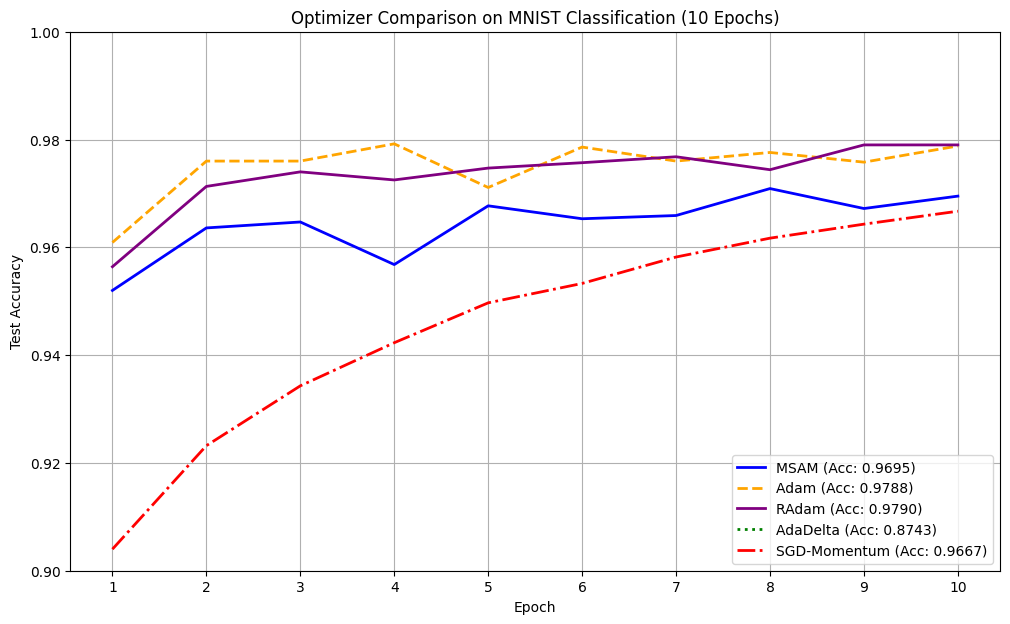

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# --- Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 64

# --- Optimizer Parameters ---
CUSTOM_LR = 0.001
CUSTOM_BETAS = (0.9, 0.99) # MSAM Custom Beta2
CUSTOM_EPS = 1e-8

ADAM_DEFAULT_LR = 0.001
ADAM_DEFAULT_BETAS = (0.9, 0.999) # Adam Default Beta2
ADAM_DEFAULT_EPS = 1e-8

# RAdam Parameters (LR=0.001, Beta1=0.9 as requested, Beta2 standard 0.999)
RADAM_DEFAULT_LR = 0.001
RADAM_DEFAULT_BETAS = (0.9, 0.999)
RADAM_DEFAULT_EPS = 1e-8 

ADADELTA_DEFAULT_LR = 0.001
ADADELTA_DEFAULT_RHO = 0.9
ADADELTA_DEFAULT_EPS = 1e-6

SGD_MOM_DEFAULT_LR = 0.001
SGD_MOM_DEFAULT_MOMENTUM = 0.9

# --- Custom MSAM Optimizer ---
class MSAM(torch.optim.Optimizer):
    """
    Momentum-Adaptive Directional Adam (MADAM) implementation for PyTorch.
    Differs from Adam by calculating the adaptive term 'v' based on squared momentum (m^2)
    instead of squared gradient (grad^2).
    """
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8):
        defaults = dict(lr=lr, betas=betas, eps=eps)
        super(MSAM, self).__init__(params, defaults)
        self.iterations = 0

    @torch.no_grad()
    def step(self):
        self.iterations += 1
        
        for group in self.param_groups:
            lr, beta1, beta2 = group["lr"], group["betas"][0], group["betas"][1]
            eps = group["eps"]
            
            t = self.iterations

            denom_b1 = 1.0 - beta1 ** t
            denom_b2 = 1.0 - beta2 ** t
            
            for p in group["params"]:
                if p.grad is None:
                    continue

                grad = p.grad

                state = self.state[p]

                if "m" not in state:
                    state["m"] = torch.zeros_like(p) 
                if "v" not in state:
                    state["v"] = torch.zeros_like(p) 

                m = state["m"]
                v = state["v"]

                # Update first moment (momentum)
                m.mul_(beta1).add_(grad, alpha=(1.0 - beta1))

                # Update second moment (adaptive term) using squared momentum (m^2)
                m_squared = m.pow(2)
                v.mul_(beta2).add_(m_squared, alpha=(1.0 - beta2))

                # Bias correction
                mhat = m / denom_b1
                vhat = v / denom_b2

                # Update parameters
                p.addcdiv_(mhat, (vhat.sqrt() + eps), value=-lr)


# --- Model and Data Setup ---
class SimpleNet(nn.Module):
    """Simple 3-layer fully connected network for MNIST."""
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        x = x.view(-1, 784) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load MNIST data
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset  = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=1000, shuffle=False)

# --- Test and Train Functions ---
def test(model, test_loader):
    """Evaluates the model's accuracy on the test set."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, predicted = out.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
    return correct / total

def train(model, optimizer, name, params_info):
    """Trains the model for the specified number of epochs."""
    model.train()
    acc_list = []
    
    param_str = ", ".join(f"{k.upper()}={v}" for k, v in params_info.items())
    print(f"\n=== Training {name} ({param_str}) ===")

    for epoch in range(1, EPOCHS + 1):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            out = model(x)
            loss = F.cross_entropy(out, y)
            loss.backward()
            optimizer.step()

        test_acc = test(model, test_loader)
        acc_list.append(test_acc)
        
        print(f"Epoch {epoch}/{EPOCHS} → Test Acc: {test_acc:.4f}")

    return acc_list


results = {}

# 1. MSAM Test
model_msam = SimpleNet().to(device)
optimizer_msam = MSAM(model_msam.parameters(), lr=CUSTOM_LR, betas=CUSTOM_BETAS, eps=CUSTOM_EPS)
results['MSAM'] = train(model_msam, optimizer_msam, name='MSAM', 
                        params_info={'lr': CUSTOM_LR, 'b1': CUSTOM_BETAS[0], 'b2': CUSTOM_BETAS[1]})

# 2. Adam Test
model_adam = SimpleNet().to(device)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=ADAM_DEFAULT_LR, betas=ADAM_DEFAULT_BETAS, eps=ADAM_DEFAULT_EPS)
results['Adam'] = train(model_adam, optimizer_adam, name='Adam (Default)', 
                        params_info={'lr': ADAM_DEFAULT_LR, 'b1': ADAM_DEFAULT_BETAS[0], 'b2': ADAM_DEFAULT_BETAS[1]})

# 3. RAdam Test (New addition)
model_radam = SimpleNet().to(device)
optimizer_radam = torch.optim.RAdam(model_radam.parameters(), lr=RADAM_DEFAULT_LR, betas=RADAM_DEFAULT_BETAS, eps=RADAM_DEFAULT_EPS)
results['RAdam'] = train(model_radam, optimizer_radam, name='RAdam (Adjusted Params)', 
                        params_info={'lr': RADAM_DEFAULT_LR, 'b1': RADAM_DEFAULT_BETAS[0], 'b2': RADAM_DEFAULT_BETAS[1]})

# 4. AdaDelta Test
model_adadelta = SimpleNet().to(device)
optimizer_adadelta = torch.optim.Adadelta(model_adadelta.parameters(), lr=ADADELTA_DEFAULT_LR, rho=ADADELTA_DEFAULT_RHO, eps=ADADELTA_DEFAULT_EPS)
results['AdaDelta'] = train(model_adadelta, optimizer_adadelta, name='AdaDelta (Default)', 
                            params_info={'lr': ADADELTA_DEFAULT_LR, 'rho': ADADELTA_DEFAULT_RHO})

# 5. SGD-Momentum Test
model_sgd_mom = SimpleNet().to(device)
optimizer_sgd_mom = torch.optim.SGD(model_sgd_mom.parameters(), lr=SGD_MOM_DEFAULT_LR, momentum=SGD_MOM_DEFAULT_MOMENTUM)
results['SGD-Momentum'] = train(model_sgd_mom, optimizer_sgd_mom, name='SGD-Momentum (Default)', 
                                 params_info={'lr': SGD_MOM_DEFAULT_LR, 'momentum': SGD_MOM_DEFAULT_MOMENTUM})


# --- Final Results and Plot ---

final_msam_acc = results['MSAM'][-1]
final_adam_acc = results['Adam'][-1]
final_radam_acc = results['RAdam'][-1]
final_adadelta_acc = results['AdaDelta'][-1]
final_sgd_mom_acc = results['SGD-Momentum'][-1]


print("\n==============================================")
print("MNIST Optimization Final Results (10 Epochs)")
print("==============================================")
print(f"MSAM (LR={CUSTOM_LR}, B2={CUSTOM_BETAS[1]}) Final Test Accuracy: {final_msam_acc:.4f}")
print(f"Adam (LR={ADAM_DEFAULT_LR}, B2={ADAM_DEFAULT_BETAS[1]}) Final Test Accuracy: {final_adam_acc:.4f}")
print(f"RAdam (LR={RADAM_DEFAULT_LR}, B2={RADAM_DEFAULT_BETAS[1]}) Final Test Accuracy: {final_radam_acc:.4f}")
print(f"AdaDelta (LR={ADADELTA_DEFAULT_LR}, Rho={ADADELTA_DEFAULT_RHO}) Final Test Accuracy: {final_adadelta_acc:.4f}")
print(f"SGD-Momentum (LR={SGD_MOM_DEFAULT_LR}, Mom={SGD_MOM_DEFAULT_MOMENTUM}) Final Test Accuracy: {final_sgd_mom_acc:.4f}")

plt.figure(figsize=(12, 7))

plt.plot(range(1, EPOCHS + 1), results['MSAM'], 
           label=f'MSAM (Acc: {final_msam_acc:.4f})', linewidth=2, color='blue')
plt.plot(range(1, EPOCHS + 1), results['Adam'], 
           label=f'Adam (Acc: {final_adam_acc:.4f})', linestyle='--', linewidth=2, color='orange')
plt.plot(range(1, EPOCHS + 1), results['RAdam'], 
           label=f'RAdam (Acc: {final_radam_acc:.4f})', linestyle='-', linewidth=2, color='purple')
plt.plot(range(1, EPOCHS + 1), results['AdaDelta'], 
           label=f'AdaDelta (Acc: {final_adadelta_acc:.4f})', linestyle=':', linewidth=2, color='green')
plt.plot(range(1, EPOCHS + 1), results['SGD-Momentum'], 
           label=f'SGD-Momentum (Acc: {final_sgd_mom_acc:.4f})', linestyle='-.', linewidth=2, color='red')

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.title(f"Optimizer Comparison on MNIST Classification (10 Epochs)")
plt.legend(loc='lower right')
plt.grid(True)
plt.xticks(range(1, EPOCHS + 1))
plt.ylim(0.9, 1.0) 
plt.show()